In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

## Data import

In [9]:
df = pd.read_csv('CN_DB.csv')
print(df.columns)

Index(['suject_id', 'timestamp', 'season', 'city', 'climate', 'building_type',
       'heating_type', 'gender', 'age', 'ht', 'wt', 'thermal_sensation',
       'thermal_comfort', 'thermal_acceptability', 'clo', 'met', 'ta', 'rh',
       'vel', 'tg', 'top', 'tr', 't_out_min', 't_out_monthly', 'latitude'],
      dtype='object')


In [10]:
df_city = pd.read_csv('CN_DB_CITY.csv')
df_city.head()

,city,records,thermal_sensation,ta,top,tg,clo,latitude,tn_a,comfz_a,tn_b,comfz_b,tn_g,p_dh
0,HainanSanya,5,0.60,24.88,24.88,24.88,0.33,18.25,NaN,NaN,NaN,NaN,23.38,0.0
1,GuangdongGuangzhou,997,-0.01,23.85,23.88,23.88,0.86,23.13,24.01,17.61,23.88,0.24,23.91,0.0
2,YunnanKunming,415,-1.15,13.62,13.62,19.22,0.65,24.87,19.97,9.36,15.28,2.44,22.10,0.0
3,FujianFuzhou,7,-0.71,18.10,18.10,18.10,0.35,26.08,NaN,NaN,NaN,NaN,19.89,0.0
4,FujianZhenjiang,2,-0.50,22.90,22.90,22.90,0.31,26.10,NaN,NaN,NaN,NaN,24.15,0.0


Calcualte the distance of each city to Huai River (33˚N)

In [43]:
df_city['distance'] = df_city['latitude'] - 33

## Sharp Threshold Assumption
All cities have disctrict heating systems if the distance is >= 0</br>
No city has disctrict heating systems if the distance is < 0

In [92]:
# create a new dummy variable based on the distance
df_rd = df_city.assign(threshold=(df_city["distance"] > 0).astype(int))

### Globe temp (tg)
tg is the best, because it is directly measureed, and only has measurement error </br>
ta is directly measured, but is less representative of the thermal enviornment </br>
top, operative temperature, is calculated by ta and tr, so it has two measurement error and one calculation error

In [90]:
model = smf.wls("tg~distance*threshold", df_rd, weights=df_rd["records"]).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.6299,1.312,12.672,0.000,13.946,19.314
distance,-0.5614,0.249,-2.254,0.032,-1.071,-0.052
threshold,5.2973,1.761,3.008,0.005,1.696,8.899
distance:threshold,0.5296,0.284,1.868,0.072,-0.050,1.110


The coef of the threshold is the causal effect, which is 5.3 ˚C, p-value is 0.005, and the 95% CI is [1.7, 8.9]

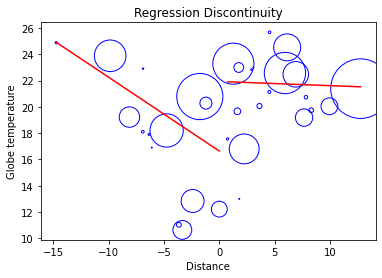

In [91]:
plt.scatter(df_rd['distance'], df_rd['tg'], s=df_rd['records'], facecolors='none', edgecolors='b')
# plot less than 0 distance for model.fittedvalues
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
# plot larger than 0 distance for model.fittedvalues
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.xlabel('Distance')
plt.ylabel('Globe temperature')
plt.title("Regression Discontinuity")
plt.show()


### Clothing insulations (clo)

In [68]:
model = smf.wls("clo~distance*threshold", df_rd, weights=df_rd["records"]).fit()
print("Effect is:", model.summary().tables[1][3][1])
print("pvalue is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Effect is:    -0.2748
pvalue is:  0.087


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.1598,0.115,10.048,0.000,0.924,1.396
distance,0.0357,0.022,1.628,0.114,-0.009,0.080
threshold,-0.2748,0.155,-1.774,0.087,-0.592,0.042
distance:threshold,-0.0317,0.025,-1.272,0.214,-0.083,0.019


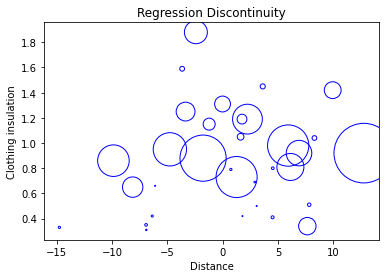

In [106]:
plt.scatter(df_rd['distance'], df_rd['clo'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.xlabel('Distance')
plt.ylabel('Clothing insulation')
plt.title("No regression discontinuity")
plt.show()


Conclusion: the policy doesn't have a statistically significant effect on clothing insulations </br>
Assuming that the policy affects clothing insulation only through indoor thermal environment, represented by tg </br>
Then, ~5˚C indoor tg increase doesn't have a causal effect on clothing insulation, from a population perspective

## Causal effect of the plicy on neutral temperature (tricky metric)


In [101]:
# needs one more non-NaN neutral temperature/comfort zone calcualted by regression approach a and b
# neutral temperature calcualted by Griffth method, and using measured globe temperature
model = smf.wls("tn_g~distance*threshold", df_rd).fit()
print("Causal effect is:", model.summary().tables[1][3][1])
print("p-value is:", model.summary().tables[1][3][4])
model.summary().tables[1]

Causal effect is:     4.6279
pvalue is:  0.012


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,15.2586,1.296,11.770,0.000,12.607,17.910
distance,-0.6760,0.196,-3.448,0.002,-1.077,-0.275
threshold,4.6279,1.733,2.671,0.012,1.084,8.171
distance:threshold,0.8284,0.277,2.993,0.006,0.262,1.394


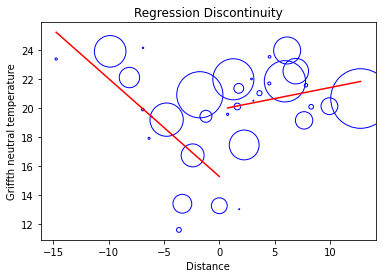

In [102]:
# scatter plot tn_g vs distance
plt.scatter(df_rd['distance'], df_rd['tn_g'], s=df_rd['records'], facecolors='none', edgecolors='b')
# plot less than 0 distance for model.fittedvalues
plt.plot(df_rd['distance'][df_rd['distance'] < 0], model.fittedvalues[df_rd['distance'] < 0], color='red')
# plot larger than 0 distance for model.fittedvalues
plt.plot(df_rd['distance'][df_rd['distance'] >= 0], model.fittedvalues[df_rd['distance'] >= 0], color='red')
plt.xlabel('Distance')
plt.ylabel('Griffth neutral temperature')
plt.title("Regression Discontinuity")
plt.show()

Assuming that the policy can only affect the neutral temperature through indoor thermal enviornment, represented by the tg. Then the causal effect of indoor globe temperature on neutral temperature is 4.6279/5.2973 = 0.87 (95% CI:0.64, 0.92)

In [103]:
# weighted linear regression of neutral temperature against globe temperature
model = smf.wls("tn_g~tg", df_rd, weights=df_rd["records"]).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.2523,0.863,7.241,0.000,4.491,8.013
tg,0.6973,0.041,16.892,0.000,0.613,0.782


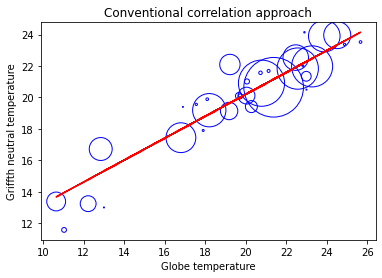

In [105]:
plt.scatter(df_rd['tg'], df_rd['tn_g'], s=df_rd['records'], facecolors='none', edgecolors='b')
plt.plot(df_rd['tg'], model.fittedvalues, color='red')
plt.xlabel('Globe temperature')
plt.ylabel('Griffth neutral temperature')
plt.title("Conventional correlation approach")
plt.show()

## Fuzzy Threshold Assumption
All cities have disctrict heating systems if the distance is > 2
No city has disctrict heating systems if the distance is < -2